In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel
from collections import defaultdict

In [2]:
df = pd.read_csv("./kieranFeatures_1-30_14-Nov-2024_rawSA.csv").replace([np.inf, -np.inf], np.nan).interpolate() # Perform linear interpolation on all non-valid numbers

df["Lv_1_Lo"] = (df["SA1"] >= 5).astype(int)
df["Lv_2_Lo"] = (df["SA2"] >= 5).astype(int)
df["Lv_3_Lo"] = (df["SA3"] >= 5).astype(int)
df["Tot_Lo"] = (df["SAtotal"] >= 15).astype(int)

ids = df.iloc[:, 0]
trial_nums = df.iloc[:, 1]
predictors_df = df.iloc[:, 2:df.shape[1] - 8]
outcomes_df = df.iloc[:, df.shape[1] - 8:]
outcomes_df_shuffled = outcomes_df.copy()

# Shuffle Labels
outcomes_df_shuffled["Lv_1_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_1_Lo"])
outcomes_df_shuffled["Lv_2_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_2_Lo"])
outcomes_df_shuffled["Lv_3_Lo"] = np.random.permutation(outcomes_df_shuffled["Lv_3_Lo"])
outcomes_df_shuffled["Tot_Lo"] = np.random.permutation(outcomes_df_shuffled["Tot_Lo"])

# Free Memory
del df

In [3]:
f1_scores = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

accuracy_scores = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

CV_models = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

relaxed_LASSO_features = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

f1_scores_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

accuracy_scores_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

CV_models_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

relaxed_LASSO_features_shuffled = {
    "Lv_1_Lo": [],
    "Lv_2_Lo": [],
    "Lv_3_Lo": [],
    "Tot_Lo": []
}

# Sum of F1 and accuracy score
def scorer(estimator, predictors, outcomes):
    return f1_score(outcomes, estimator.predict(predictors), average = "macro") + balanced_accuracy_score(outcomes, estimator.predict(predictors))

In [5]:
def evaluate_models(pred_df, out_df, ids, trial_nums):
    f1_scores = defaultdict(list)
    accuracy_scores = defaultdict(list)
    models = defaultdict(list)
    relaxed_LASSO_selected_features = []

    # Obtain 5 tes t folds stratifying by participant ID
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    for i, (CV_idx, test_idx) in enumerate(skf.split(pred_df, ids)):
        # Train-Test Split for the Fold
        ids_CV = ids.iloc[CV_idx].values
        # ids_test = ids.iloc[test_idx].values
        # trial_nums_CV = ids.iloc[CV_idx].values
        # trial_nums_test = ids.iloc[test_idx].values
        pred_CV = pred_df.iloc[CV_idx, :].values
        pred_test = pred_df.iloc[test_idx, :].values
        out_CV = out_df.iloc[CV_idx].values
        out_test = out_df.iloc[test_idx].values

        # Standardize data
        scaler = StandardScaler()
        pred_CV = scaler.fit_transform(pred_CV)
        pred_test = scaler.transform(pred_test)

        # Setup Cross Validation Object
        CV_skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        
        # Initialize Models to Train
        no_penalty_model = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None
        )

        Ridge_model = LogisticRegressionCV(
            Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            cv = CV_skf.split(pred_CV, ids_CV), 
            fit_intercept = False,
            class_weight = "balanced", 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 20000, 
            scoring = scorer, 
            refit = True
        )

        LASSO_model = LogisticRegressionCV(
            Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            cv = CV_skf.split(pred_CV, ids_CV), 
            fit_intercept = False,
            class_weight = "balanced",
            penalty = "l1", 
            solver = "saga", 
            n_jobs = -1, 
            max_iter = 20000, 
            scoring = scorer, 
            refit = True
        )

        relaxed_LASSO_model = LogisticRegression(
            fit_intercept = False,
            solver = "saga",
            n_jobs = -1,
            max_iter = 20000,
            class_weight = "balanced",
            penalty = None
        )

        # Fit Models
        no_penalty_model.fit(pred_CV, out_CV)
        Ridge_model.fit(pred_CV, out_CV)
        LASSO_model.fit(pred_CV, out_CV)

        # Obtain and fit "Relaxed LASSO" Model
        selector = SelectFromModel(LASSO_model, threshold = "mean", prefit = True)
        selected_features = selector.get_support()
        pred_CV_selected = pred_CV[:, selected_features]
        pred_test_selected = pred_test[:, selected_features]
        relaxed_LASSO_model.fit(pred_CV_selected, out_CV)

        # Append F1 Scores
        f1_scores["No Penalty"].append(f1_score(out_test, no_penalty_model.predict(pred_test), average = "macro"))
        f1_scores["Ridge"].append(f1_score(out_test, Ridge_model.predict(pred_test), average = "macro"))
        f1_scores["LASSO"].append(f1_score(out_test, LASSO_model.predict(pred_test), average = "macro"))
        f1_scores["Relaxed LASSO"].append(f1_score(out_test, relaxed_LASSO_model.predict(pred_test_selected), average = "macro"))

        # Append accuracy Scores
        accuracy_scores["No Penalty"].append(balanced_accuracy_score(out_test, no_penalty_model.predict(pred_test)))
        accuracy_scores["Ridge"].append(balanced_accuracy_score(out_test, Ridge_model.predict(pred_test)))
        accuracy_scores["LASSO"].append(balanced_accuracy_score(out_test, LASSO_model.predict(pred_test)))
        accuracy_scores["Relaxed LASSO"].append(balanced_accuracy_score(out_test, relaxed_LASSO_model.predict(pred_test_selected)))

        # Remove generator from models to allow pickling
        Ridge_model.set_params(cv = None)
        LASSO_model.set_params(cv = None)

        # Add Models and Scores to Dictionaries
        models["No Penalty"].append(no_penalty_model)
        models["Ridge"].append(Ridge_model)
        models["LASSO"].append(LASSO_model)
        models["Relaxed LASSO"].append(relaxed_LASSO_model)

        # Store selected features for relaxed LASSO
        relaxed_LASSO_selected_features.append(selected_features)

    return f1_scores, accuracy_scores, models, relaxed_LASSO_selected_features

In [6]:
# 94 mins
outcome_var = "Lv_1_Lo"
f1_scores[outcome_var], accuracy_scores[outcome_var], CV_models[outcome_var], relaxed_LASSO_features[outcome_var] = evaluate_models(predictors_df, outcomes_df[outcome_var], ids, trial_nums)

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


In [8]:
f1_scores_shuffled[outcome_var], accuracy_scores_shuffled[outcome_var], CV_models_shuffled[outcome_var], relaxed_LASSO_features_shuffled[outcome_var] = evaluate_models(predictors_df, outcomes_df_shuffled[outcome_var], ids, trial_nums)

/home/jshen/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


In [9]:
# # Save data
# with open("./10_Fold_Test_Split.pkl", "wb") as f:
#     pickle.dump((f1_scores, accuracy_scores, CV_models, relaxed_LASSO_features, f1_scores_shuffled, accuracy_scores_shuffled, CV_models_shuffled, relaxed_LASSO_features_shuffled), f)

In [4]:
# Load data
with open("./10_Fold_Test_Split.pkl", "rb") as f:
    f1_scores, accuracy_scores, CV_models, relaxed_LASSO_features, f1_scores_shuffled, accuracy_scores_shuffled, CV_models_shuffled, relaxed_LASSO_features_shuffled = pickle.load(f)

In [5]:
# def graph_folds(test_scores, test_scores_shuffled, predictors_df, outcomes_df, outcome_var, metric):
#     width = 0.2
#     x_vals = np.arange(1, 6)
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
#     fig.set_figheight(5)
#     fig.set_figwidth(20)

#     always_true_line = (np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var])) / (np.sum(outcomes_df[outcome_var]) / len(outcomes_df[outcome_var]) + 1)
#     always_false_line = ((len(outcomes_df[outcome_var]) - np.sum(outcomes_df[outcome_var])) / len(outcomes_df[outcome_var])) / ((len(outcomes_df[outcome_var]) - np.sum(outcomes_df[outcome_var])) / len(outcomes_df[outcome_var]) + 1)

#     #
#     # Non-Shuffled Models
#     #

#     # No Penalty
#     ax1.bar(x_vals - width * 1.5, test_scores[outcome_var]["No Penalty"], width, label = "No Penalty")
#     for i in x_vals - 1:
#         ax1.text(i - width * 1.5 + 1, test_scores[outcome_var]["No Penalty"][i], round(test_scores[outcome_var]["No Penalty"][i], 3), ha = "center")

#     # Ridge
#     ax1.bar(x_vals - width * 0.5, test_scores[outcome_var]["Ridge"], width, label = "Ridge")
#     for i in x_vals - 1:
#         ax1.text(i - width * 0.5 + 1, test_scores[outcome_var]["Ridge"][i], round(test_scores[outcome_var]["Ridge"][i], 3), ha = "center")

#     # LASSO
#     ax1.bar(x_vals + width * 0.5, test_scores[outcome_var]["LASSO"], width, label = "LASSO")
#     for i in x_vals - 1:
#         ax1.text(i + width * 0.5 + 1, test_scores[outcome_var]["LASSO"][i], round(test_scores[outcome_var]["LASSO"][i], 3), ha = "center")

#     # Modified LASSO
#     ax1.bar(x_vals + width * 1.5, test_scores[outcome_var]["Relaxed LASSO"], width, label = "Modified LASSO")
#     for i in x_vals - 1:
#         ax1.text(i + width * 1.5 + 1, test_scores[outcome_var]["Relaxed LASSO"][i], round(test_scores[outcome_var]["Relaxed LASSO"][i], 3), ha = "center")

#     # Baselines
#     if metric == "F1 Score":
#         ax1.axhline(y = always_true_line, color = "r", label = "Always True")
#         ax1.axhline(y = always_false_line, color = "orange", label = "Always False")
#     ax1.axhline(y = 0.5, color = "black")

#     ax1.set_title("Actual Data")

#     ax1.set_ylim([0.2, 0.7])

#     #
#     # Shuffled Models
#     #

#     # No Penalty
#     ax2.bar(x_vals - width * 1.5, test_scores_shuffled[outcome_var]["No Penalty"], width, label = "No Penalty")
#     for i in x_vals - 1:
#         ax2.text(i - width * 1.5 + 1, test_scores_shuffled[outcome_var]["No Penalty"][i], round(test_scores_shuffled[outcome_var]["No Penalty"][i], 3), ha = "center")

#     # Ridge
#     ax2.bar(x_vals - width * 0.5, test_scores_shuffled[outcome_var]["Ridge"], width, label = "Ridge")
#     for i in x_vals - 1:
#         ax2.text(i - width * 0.5 + 1, test_scores_shuffled[outcome_var]["Ridge"][i], round(test_scores_shuffled[outcome_var]["Ridge"][i], 3), ha = "center")

#     # LASSO
#     ax2.bar(x_vals + width * 0.5, test_scores_shuffled[outcome_var]["LASSO"], width, label = "LASSO")
#     for i in x_vals - 1:
#         ax2.text(i + width * 0.5 + 1, test_scores_shuffled[outcome_var]["LASSO"][i], round(test_scores_shuffled[outcome_var]["LASSO"][i], 3), ha = "center")

#     # Modified LASSO
#     ax2.bar(x_vals + width * 1.5, test_scores_shuffled[outcome_var]["Relaxed LASSO"], width, label = "Modified LASSO")
#     for i in x_vals - 1:
#         ax2.text(i + width * 1.5 + 1, test_scores_shuffled[outcome_var]["Relaxed LASSO"][i], round(test_scores_shuffled[outcome_var]["Relaxed LASSO"][i], 3), ha = "center")

#     # Baselines
#     if metric == "F1 Score":
#         ax2.axhline(y = always_true_line, color = "r",  label = "Always True")
#         ax2.axhline(y = always_false_line, color = "orange", label = "Always False")
#     ax2.axhline(y = 0.5, color = "black")

#     ax2.set_title("Shuffled Labels")

#     #
#     # Plot Adjustments
#     #

#     fig.supxlabel("Test Fold")
#     fig.supylabel(metric)
#     fig.suptitle(metric + " of Model Type by Test Folds for " + outcome_var)

#     handles, labels = ax1.get_legend_handles_labels()
#     fig.legend(handles, labels, loc = "upper right")

#     fig.tight_layout()

In [109]:
def graph_folds(test_scores, test_scores_shuffled, predictors_df, outcomes_df, outcome_var, metric, penalty):
    # Intiailize Baselines
    if metric == "F1 Score":
        always_true_line = f1_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]), average = "macro")
        always_false_line = f1_score(outcomes_df[outcome_var], np.array([0 for _ in range(len(outcomes_df[outcome_var]))]), average = "macro")
    elif metric == "Balanced Accuracy":
        always_true_line = balanced_accuracy_score(outcomes_df[outcome_var], np.array([1 for _ in range(len(outcomes_df[outcome_var]))]))
        always_false_line = balanced_accuracy_score(outcomes_df[outcome_var], np.array([0 for _ in range(len(outcomes_df[outcome_var]))]))

    # Plot Actual vs Shuffled
    for i, (actual_score, shuffled_score) in enumerate(zip(test_scores[outcome_var][penalty], test_scores_shuffled[outcome_var][penalty])):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Actual Data Boxplot
    plt.boxplot(test_scores[outcome_var][penalty], vert = True, positions = [-0.1])

    # Shuffled Data Boxplot
    plt.boxplot(test_scores_shuffled[outcome_var][penalty], vert = True, positions = [1.1])

    # Baselines
    plt.axhline(y = always_true_line, color = "r", label = "Always True", linestyle = "--")
    plt.axhline(y = always_false_line, color = "orange", label = "Always False", linestyle = "--")
    plt.axhline(y = 0.5, color = "black", label = "0.5 Line", linestyle = "--")

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])

    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])

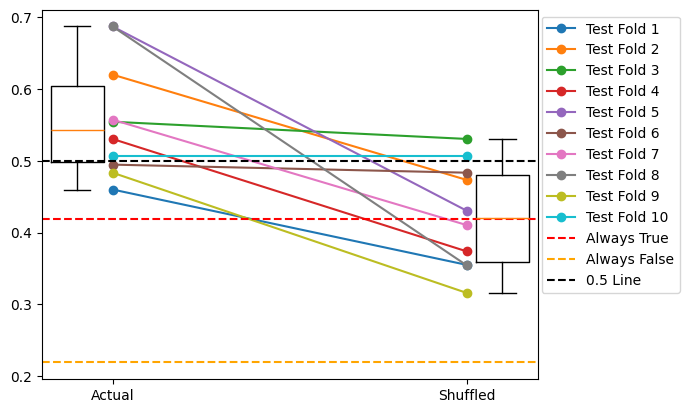

In [110]:
graph_folds(f1_scores, f1_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Lo", "F1 Score", "No Penalty")

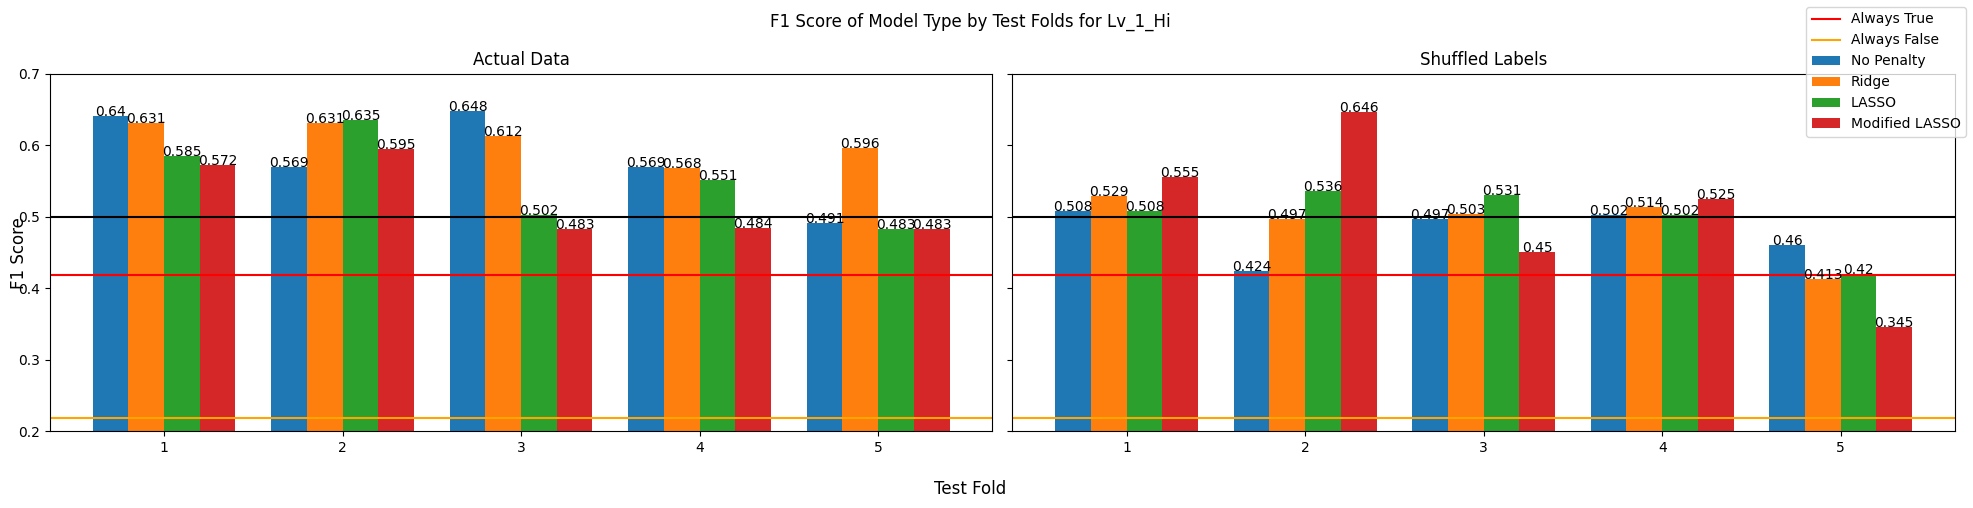

In [6]:
graph_folds(f1_scores, f1_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Hi", "F1 Score")

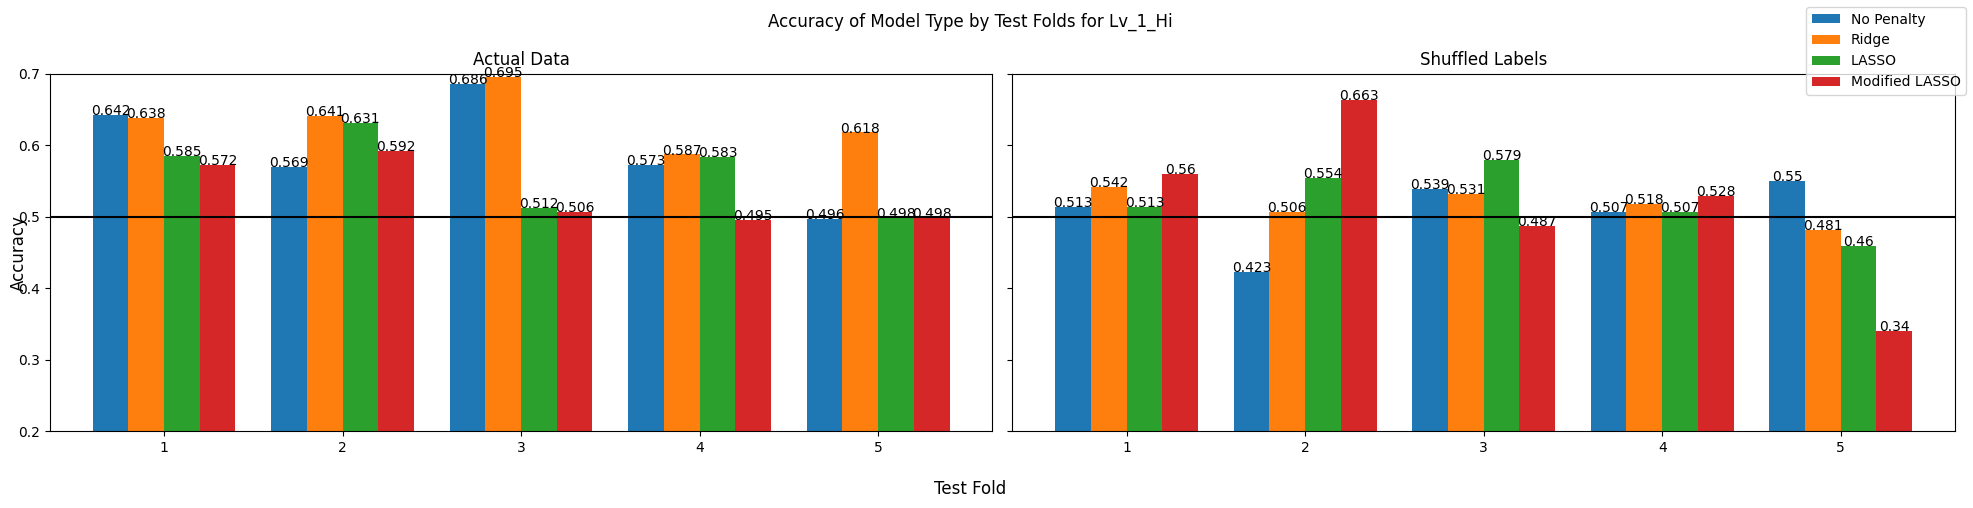

In [7]:
graph_folds(accuracy_scores, accuracy_scores_shuffled, predictors_df, outcomes_df, "Lv_1_Hi", "Accuracy")

In [13]:
# Get number of features
print("Actual Data")
for i in range(5):
    print(np.sum(CV_models["Lv_1_Hi"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models["Lv_1_Hi"]["Relaxed LASSO"][i].coef_[0] != 0))

print("Shuffled")
for i in range(5):
    print(np.sum(CV_models_shuffled["Lv_1_Hi"]["LASSO"][i].coef_[0] != 0), np.sum(CV_models_shuffled["Lv_1_Hi"]["Relaxed LASSO"][i].coef_[0] != 0))

Actual Data
1090 881
5923 1787
114 111
102 102
115 113
Shuffled
110 107
97 94
117 116
4725 1833
102 101


In [7]:
f1_scores["Lv_1_Hi"]["No Penalty"]

[np.float64(0.45993031358885017),
 np.float64(0.6198439241917503),
 np.float64(0.5542483660130719),
 np.float64(0.5303030303030303),
 np.float64(0.6868686868686869),
 np.float64(0.4945652173913043),
 np.float64(0.5571428571428572),
 np.float64(0.6868686868686869),
 np.float64(0.4833333333333333),
 np.float64(0.5067319461444308)]

In [8]:
f1_scores_shuffled["Lv_1_Hi"]

KeyError: ''

0 0.45993031358885017 0.35495716034271724
1 0.6198439241917503 0.47320261437908495
2 0.5542483660130719 0.5303030303030303
3 0.5303030303030303 0.3737373737373737
4 0.6868686868686869 0.4302702702702703
5 0.4945652173913043 0.4833333333333333
6 0.5571428571428572 0.41032608695652173
7 0.6868686868686869 0.35416666666666663
8 0.4833333333333333 0.3159117305458769
9 0.5067319461444308 0.5067319461444308


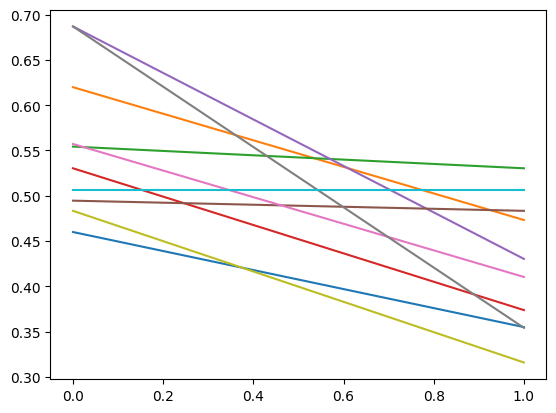

In [30]:
for i, (actual_score, shuffled_score) in enumerate(zip(f1_scores["Lv_1_Lo"]["No Penalty"], f1_scores_shuffled["Lv_1_Lo"]["No Penalty"])):
    print(i, actual_score, shuffled_score)
    plt.plot([0, 1], [actual_score, shuffled_score])

In [112]:
np.median(f1_scores["Lv_1_Lo"]["No Penalty"])

np.float64(0.5422756981580511)